## LSTM generating model

Import libs and download data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/NLP-2023/lyrics-data.csv', error_bad_lines=False, engine="python")

<ipython-input-3-10eb1d740ea0>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/drive/MyDrive/NLP-2023/lyrics-data.csv', error_bad_lines=False, engine="python")


In [4]:
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


Data preprocessing.

In [5]:
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)

In [6]:
df.shape

(379931, 2)

In [7]:
df['language'].value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

Filter non english songs.

In [8]:
# take only english songs
df = df[df['language']=='en']

In [9]:
gen_df = df[:100]
gen_df

,Lyric,language
69,I feel so unsure\nAs I take your hand and lead...,en
86,"Don't let them fool, ya\nOr even try to school...",en
88,"Baby, let's cruise, away from here\nDon't be c...",en
111,"Know it sounds funny\nBut, I just can't stand ...",en
140,You've got that look again\nThe one I hoped I ...,en
...,...,...
4817,Go out tonight\nNice night\nStay out all night...,en
4818,I love your face\nYou love the taste\nThat sug...,en
4819,I love your face\nYou love the taste\nThat sug...,en
4820,Sometimes these walls seem to cave in on me\nW...,en


In [12]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,Lyric,language,Number_of_words
69,I feel so unsure\nAs I take your hand and lead...,en,299
86,"Don't let them fool, ya\nOr even try to school...",en,161
88,"Baby, let's cruise, away from here\nDon't be c...",en,159
111,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,You've got that look again\nThe one I hoped I ...,en,215


In [13]:
# statistical info
df['Number_of_words'].describe()

count     700.000000
mean      390.055714
std       189.580128
min         8.000000
25%       265.000000
50%       371.000000
75%       496.250000
max      1495.000000
Name: Number_of_words, dtype: float64

Distribution of number of words.

<ipython-input-14-8b69dec7c5b1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

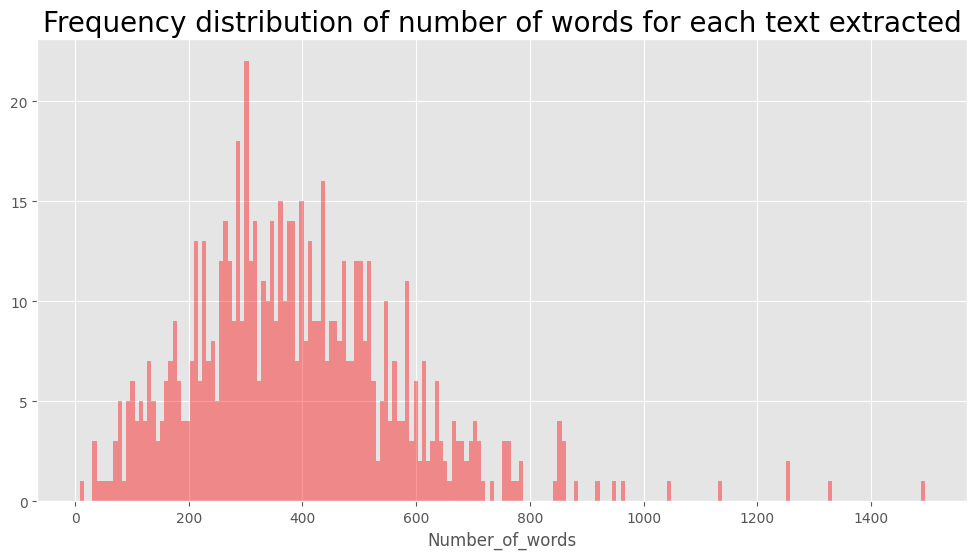

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

### Data Preprocessing

Tokenization and padding.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))

In [16]:
input_sequences = []
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
max_sequence_len = 656 #max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Creating training data.

In [17]:
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Model

Creating model.

In [ ]:
model = Sequential()

model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

# Generate new song lyrics

Now our model is ready.So lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [18]:
def generate_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(model.predict(token_list, verbose=0),axis=1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

Our function is ready so are you ready to generate your own lyrics

In [21]:
generate_song("the sky is blue", 40)

"the sky is blue you them on until then then heard of her the home are you but on the two if it right my want you're you backseat know the make me you us oh boy my be you bad as oh what"

In [22]:
generate_song("This is the beginning", 140)

"This is the beginning it heart we you with me you try in and man i have when just to 'em me whoa the while the for on do when cause up even if and i from when about if just right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right right"

In [23]:
generate_song("I am missing you", 80)

"I am missing you with me you shame in you us it i time if it i for still i different been i different i what girl the come i what now girl the can it i of let's we cause so the yeah the have when hard so and don't i for life i could don't i turn girl things will i pull back you day i let's time mine don't i dirt can't me make go i of stay we're i let's"

Save the model.

In [ ]:
from tensorflow.keras.models import load_model
model.save('song_lyrics_generator.h5')

Load model.

In [20]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/NLP-2023/song_lyrics_generator.h5')

In [21]:
complete_this_song("the sky is blue", 40)

"the sky is blue you them on until then then heard of her the home are you but on the two if it right my want you're you backseat know the make me you us oh boy my be you bad as oh what"

In [24]:
gen_df['lstm_generated_text'] = [complete_this_song(' '.join(lir.split()[:15]), 50) for lir in gen_df['Lyric']]

In [25]:
gen_df

,Lyric,language,lstm_generated_text
69,I feel so unsure\nAs I take your hand and lead...,en,I feel so unsure As I take your hand and lead ...
86,"Don't let them fool, ya\nOr even try to school...",en,"Don't let them fool, ya Or even try to school,..."
88,"Baby, let's cruise, away from here\nDon't be c...",en,"Baby, let's cruise, away from here Don't be co..."
111,"Know it sounds funny\nBut, I just can't stand ...",en,"Know it sounds funny But, I just can't stand t..."
140,You've got that look again\nThe one I hoped I ...,en,You've got that look again The one I hoped I h...
...,...,...,...
4817,Go out tonight\nNice night\nStay out all night...,en,"Go out tonight Nice night Stay out all night, ..."
4818,I love your face\nYou love the taste\nThat sug...,en,I love your face You love the taste That sugar...
4819,I love your face\nYou love the taste\nThat sug...,en,I love your face You love the taste That sugar...
4820,Sometimes these walls seem to cave in on me\nW...,en,Sometimes these walls seem to cave in on me Wh...


In [26]:
gen_df.to_csv('/content/drive/MyDrive/NLP-2023/gen_df.csv')

## GPT-2 generating model

In [27]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.4 MB/s eta 0:00:00


In [28]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv


Download the data.

In [ ]:
lyrics = pd.read_csv('/content/drive/MyDrive/NLP-2023/lyrics-data.csv')
lyrics = lyrics[lyrics['language']=='en']

In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/NLP-2023/artists-data.csv')
artists = artists[(artists['Popularity']>5)]
df = lyrics.merge(artists[['Artist', 'Genres', 'Link']], left_on='ALink', right_on='Link', how='inner')
df = df.drop(columns=['ALink','SLink','language','Link'])

In [ ]:
df = df[df['Lyric'].apply(lambda x: len(x.split(' ')) < 350)]
test_set = df.sample(n = 200)
df = df.loc[~df.index.isin(test_set.index)]

test_set = test_set.reset_index()
df = df.reset_index()

test_set['True_end_lyrics'] = test_set['Lyric'].str.split().str[-20:].apply(' '.join)
test_set['Lyric'] = test_set['Lyric'].str.split().str[:-20].apply(' '.join)

Creating song lyrics dataset.

In [29]:
class SongLyrics(Dataset):  
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = []

        for row in df['Lyric']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))               
        if truncate:
            self.lyrics = self.lyrics[:20000]
        self.lyrics_count = len(self.lyrics)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]
    
dataset = SongLyrics(df['Lyric'], truncate=True, gpt2_type="gpt2")      

Token indices sequence length is longer than the specified maximum sequence length for this model (1056 > 1024). Running this sequence through the model will result in indexing errors


Creating tokenizer and model.

In [30]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [31]:
def train(
    dataset, model, tokenizer,
    batch_size=16, epochs=5, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="",
    test_mode=False,save_model_on_epoch=False,
):
    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):

        print(f"Training epoch {epoch}")
        print(loss)
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
    return model

In [ ]:
model = train(dataset, model, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training epoch 0
0


20000it [30:44, 10.85it/s]


Training epoch 1
tensor(1.1106, device='cuda:0', grad_fn=<NllLossBackward0>)


20000it [30:45, 10.84it/s]


Training epoch 2
tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward0>)


20000it [30:44, 10.84it/s]


Training epoch 3
tensor(1.4136, device='cuda:0', grad_fn=<NllLossBackward0>)


20000it [30:44, 10.84it/s]


Training epoch 4
tensor(1.0566, device='cuda:0', grad_fn=<NllLossBackward0>)


20000it [30:46, 10.83it/s]


In [ ]:
torch.save(
    model.state_dict(),
    os.path.join("/content/drive/MyDrive/NLP-2023/slg-gpt-2_finetune_ep-5.pt"),
)

In [32]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=30, #maximum number of words
    top_p=0.8,
    temperature=1.,
):
    model.eval()
    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False
            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break
            
            if not entry_finished:
              output_list = list(generated.squeeze().numpy())
              output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
              generated_list.append(output_text)
                
    return generated_list


In [ ]:
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = generate(model.to('cpu'), tokenizer, test_data['Lyric'][i], entry_count=1)
    generated_lyrics.append(x)
  return generated_lyrics

generated_lyrics = text_generation(gen_df)

In [49]:
generated_lyrics

[["In a vine covered Shack in the mountains Bravely fighting The battle of time There's a dear one Who's wept Through life's sorrows It's that silver Haired daddy of mine Chorus (2x): If I couxd recall All the heartaches Dear ole daddy I've caused you to bear If I could erase Those lines from your face And bring back The gold to your hair If God would but Grant me the power Just to turn back The pages, please\nChorus (2x):\n\nI can feel the wafting of thunder coming down\n\nThe one who reminds me\n<|endoftext|>"],
 ["Things have come to a pretty pass Our romance is growing flat For you like this and the other While I go for this and that Goodness knows what the end will be Oh, I don't know where I'm at It looks as if we two will never be one Something must be done (Chorus) You say eether and I say eyether You say neether and I say nyther Eether, eyether, neether, nyther Let's call the whole thing off! You like potato and I like potahto You like tomato and I like tomahto Potato, potahto

Load model.

In [47]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP-2023/slg-gpt-2_finetune_ep-5.pt'))

<All keys matched successfully>

In [58]:
t_set = test_set.copy()[:15].reset_index(drop=True)

my_generations=[]

for i in range(len(generated_lyrics)):
  a = t_set['Lyric'][i].split()[-30:]
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i])
  my_generations.append(c.split(b)[-1])

t_set['Generated_lyrics'] = my_generations

final=[]

for i in range(len(t_set)):
  to_remove = t_set['Generated_lyrics'][i].split('.')[-1]
  final.append(t_set['Generated_lyrics'][i].replace(to_remove,''))

t_set['Generated_lyrics'] = final

In [1]:
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(t_set)):
  reference = t_set['True_end_lyrics'][i]
  generated = t_set['Generated_lyrics'][i]
  scores.append(sentence_bleu(reference, generated))


np.mean(scores)

0.4516254179236


In [34]:
from functools import reduce
import re
from collections import Counter
rg = str(reduce(lambda a,b: a+b, artists['Genres'].astype(str), ''))

In [35]:
top_35_genres = list(dict(Counter(list(filter(lambda x: len(x)>0, re.split(' |\n|\t|;|,', rg)))).most_common(35)).keys())
print(top_35_genres)

['Rock', 'Romântico', 'Music', 'Alternativo', 'Pop', 'Hop', 'Pop/Rock', 'Black', 'Hip', 'Soul', 'Hard', 'Heavy', 'RockRock', 'R&B', 'Sonora', 'Rap', 'Trilha', 'Pop/RockRock', 'Dance', 'Metal', 'Pop/RockPop', 'Electronica', 'RomânticoRomântico', 'PopPop', 'MusicPop', 'MusicHip', 'DancePop', 'AlternativoRock', 'RomânticoRock', 'RockPop/Rock', 'HopHip', 'RockRomântico', 'Samba', 'Country', 'RomânticoPop']


In [ ]:
def get_single_genre(genres, genres_list):
    for g in genres_list:
        if g in genres:
            return g
    return 'Other'


def get_genre_list(genres, genres_list):
    result = []
    for g in genres_list:
        if g in genres:
            result.append(g)
    return result

In [ ]:
get_single_genre('Pop; Axé; Romântico', top_35_genres)

'Romântico'

In [ ]:
get_genre_list('Pop; Axé; Romântico', top_35_genres)

['Romântico', 'Pop', 'Axé']

In [ ]:
get_single_genre('Pop; Axé; Romântico', top_35_genres) in get_genre_list('Pop; Axé; Romântico', top_35_genres)

True

In [70]:
def vectorize_genres(genres_str, valid_genres=('Rock', 'Pop', 'Hop','R&B','Rap')):
    vector = []
    for g in valid_genres:
      vector.append(1 if g in genres_str else 0)
    return vector


vectorize_genres('Folk; Country; Rock')

[1, 0, 0, 0, 0]

In [73]:
test_set['genres_vector'] = [vectorize_genres(g) for g in test_set['Genres']]
test_set

,index,SName,Lyric,Artist,Genres,True_end_lyrics,genres_vector
0,10167,That Silver Haired Daddy Of Mine,In a vine covered Shack in the mountains Brave...,Johnny Cash,Folk; Country; Rock,of time I would give all I own just to put a t...,"[1, 0, 0, 0, 0]"
1,13540,Let's Call the Whole Thing Off,Things have come to a pretty pass Our romance ...,Cyndi Lauper,Pop/Rock; Pop; Dance,we know we need each other So we better call t...,"[1, 1, 0, 0, 0]"
2,26109,A Lovely Way To Spend An Evening,"Some like a night at the movies, some like a d...",Frank Sinatra,Jazz; Clássico; Romântico,is a lovely way to spend an evening I want to ...,"[0, 0, 0, 0, 0]"
3,38232,10 Coisas Que Eu Odeio Em Você - War,"Oh, come crush me now Don't leave No one has w...",Temas de Filmes,COLETÂNEA; Trilha Sonora; Romântico; Instrumental,on And if you're peaceful when you sleep Give ...,"[0, 0, 0, 0, 0]"
4,17130,Talk,I can remember the good old days When you and ...,Kodaline,Folk; Soft Rock; Indie,"We don't, we don't need to talk about this now...","[1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
195,21169,Frail Limb Nursery,"""She lay as though she were in a trance, with ...",Slipknot,Hard Rock; Heavy Metal; Rock,what it's like to live with that? No one knows...,"[1, 0, 0, 0, 0]"
196,4728,Let You What (Interlude),"Thank you You're welcome Huh, all right (where...",Ne-yo,Hip Hop; Black Music; R&B,"so much better than I can tell you, that is if...","[0, 0, 1, 1, 0]"
197,9593,Home Ain't Where His Heart Is (Anymore),He knew how to reach me deep inside And he fou...,Shania Twain,Pop; Country; Romântico,down to love me like before Home ain't where h...,"[0, 1, 0, 0, 0]"
198,37290,The Jean Genie,A small Jean Genie snuck off to the city Strun...,David Bowie,Rock,He bites on the neon and sleeps in the capsule...,"[1, 0, 0, 0, 0]"


## BERT classification model

In [75]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


In [76]:
MAX_LEN = 16
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Creating lyrics dataset.

In [99]:
class LyricsDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.lyrics = dataframe['Lyric']
        self.targets = self.data.genres_vector
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyric = str(self.lyrics[index])
        lyric = " ".join(lyric.split())

        inputs = self.tokenizer.encode_plus(
            lyric,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_dataset = test_set.sample(frac=train_size,random_state=200)
valid_dataset = test_set.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = LyricsDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = LyricsDataset(valid_dataset, tokenizer, MAX_LEN)

Creating dataloaders.

In [101]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

Creating BERT model.

In [103]:
device = torch.device("cuda")

In [110]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [102]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [111]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [112]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [113]:
val_targets=[]
val_outputs=[]

In [114]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
      
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/NLP-2023/current_checkpoint.pt'
best_model = '/content/drive/MyDrive/NLP-2023/best_model/best_model.pt'
trained_model = train_model(1, 5, np.Inf, training_loader, validation_loader, model, 
                      optimizer,checkpoint_path,best_model)